In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import catboost as ctb
from sklearn.metrics import log_loss
import numpy as np
from sklearn.model_selection import train_test_split

In [61]:
train_set = pd.read_csv('train_prepared.csv', encoding='utf-8')
test_set = pd.read_csv('test_prepared.csv', encoding='utf-8')

train_set = train_set.replace([np.inf,-np.inf], np.nan)
test_set = test_set.replace([np.inf,-np.inf], np.nan)

In [62]:
X = train_set.drop(columns=['Target', 'Opportunity_ID'])
y = train_set.Target

In [63]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import make_column_selector
from sklearn.impute import SimpleImputer

numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()

# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[
                            ('imputer', SimpleImputer()),
                            ('scaler', KBinsDiscretizer(n_bins=5, strategy='quantile'))
                        ]
                      )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols)
                        ],
                    remainder='passthrough'
                    )

In [65]:
best = {'colsample_bytree': 0.84, 
        'gamma': 0.49, 'learning_rate': 0.05, 'max_depth': 23,
        'min_child_weight': 6.0, 'n_estimators': 50, 'subsample': 0.84}

x = xgb.XGBClassifier(silent=True, **best)

pipe = Pipeline([('preprocessing', preprocessor),('rf',x)])

# Train
# ==============================================================================
# Se asigna el resultado a _ para que no se imprima por pantalla
_ = pipe.fit(X=X_train, y=y_train)

C:\Users\Francisco\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:200: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\Francisco\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:200: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\Francisco\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:200: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 11 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\Francisco\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:200: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in featur

[17:41:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:41:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [66]:
log_loss(y_test, pipe.predict_proba(X_test))

0.35811029911351544

In [67]:
log_loss(test_set.Target, pipe.predict_proba(test_set.drop(columns=['Opportunity_ID', 'Target'])))

0.45371247485432187

In [68]:
preds_x = pipe.predict_proba(X_test)

In [69]:
from sklearn.metrics import f1_score

In [70]:
print(log_loss(y_train, pipe.predict_proba(X_train)))
f1_score(y_train, pipe.predict(X_train))

0.2845815707057737


0.9088224437061646

In [71]:
print(log_loss(y_test, preds_x))
f1_score(y_test, pipe.predict(X_test))

0.35811029911351544


0.8596070915189267

In [72]:
test_preds = pipe.predict_proba(test_set.drop(columns=['Opportunity_ID', 'Target']))

In [73]:
print(log_loss(test_set.Target, test_preds))
f1_score(test_set.Target, pipe.predict(test_set.drop(columns=['Target', 'Opportunity_ID'])))

0.45371247485432187


0.7943094250148192

In [74]:
preds = pd.DataFrame(test_preds[:, 1])
preds['Opportunity_ID'] = test_set.Opportunity_ID.to_list()
preds['Real'] = test_set.Target.to_list()

In [75]:
sub = preds.loc[:, ['Opportunity_ID', 0]]
sub.columns = ['Opportunity_ID', 'Target']
sub

,Opportunity_ID,Target
0,10689,0.846601
1,10690,0.720333
2,10691,0.587200
3,10692,0.477397
4,10693,0.880576
...,...,...
1562,12364,0.913875
1563,12365,0.367553
1564,12366,0.293549
1565,12367,0.465540


In [76]:
sub.to_csv('predictions/xgb.csv', index=False)

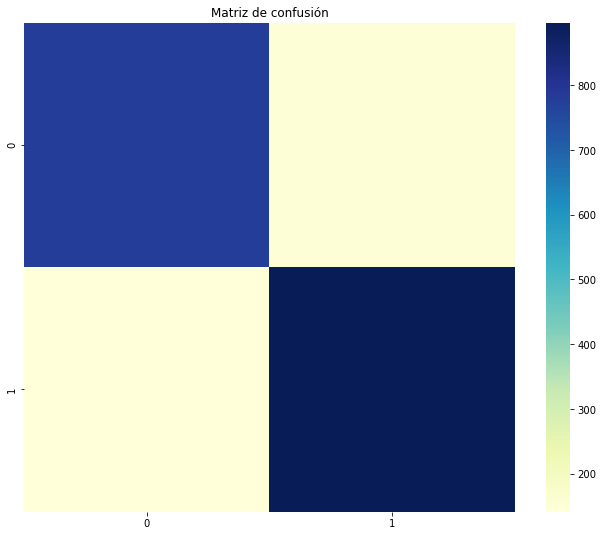

In [77]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(11, 9))
plt.title('Matriz de confusión')
sns.heatmap(confusion_matrix(y_test, pipe.predict(X_test)), cmap='YlGnBu')
plt.show()